# Bayesian linear regression
## Normal-inverse-gamma model
A example of how to perform Bayesian linear regression using the normal-inverse-gamma conjugate model.

In [1]:
import numpy as np
from scipy import stats

import matplotlib.pylab as plt
%matplotlib inline

from time import time

In [2]:
import sys
sys.path.append('../')
from bayes_linear_regression import norm_inv_gamma as nig

## Example of calibration

### 1. Generate a toy regression problem by sampling from the prior

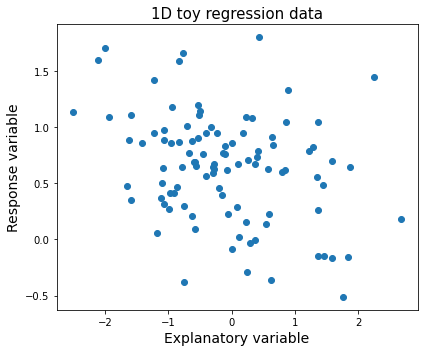

In [3]:
### 1. Generate a 1D toy regression problem by sampling from the prior
cov = np.eye(2)   
mu = np.zeros(shape=(2,1))

# Instantiate the model
prior = nig.NormalInverseGamma(a=3, b=1, mu=mu, cov=cov)

n = 100
explanatory, response, params = nig.gen_toy_data(n, prior)

fig, ax = plt.subplots(1, figsize=(6, 5))

ax.scatter(explanatory[:,1], response)
ax.set_xlabel('Explanatory variable', fontsize=14)
ax.set_ylabel('Response variable', fontsize=14)
ax.set_title('1D toy regression data', fontsize=15)

plt.tight_layout()
plt.savefig('toy_regression_data.png', dpi=150)
plt.show()

### 2. Fitting and testing the posterior

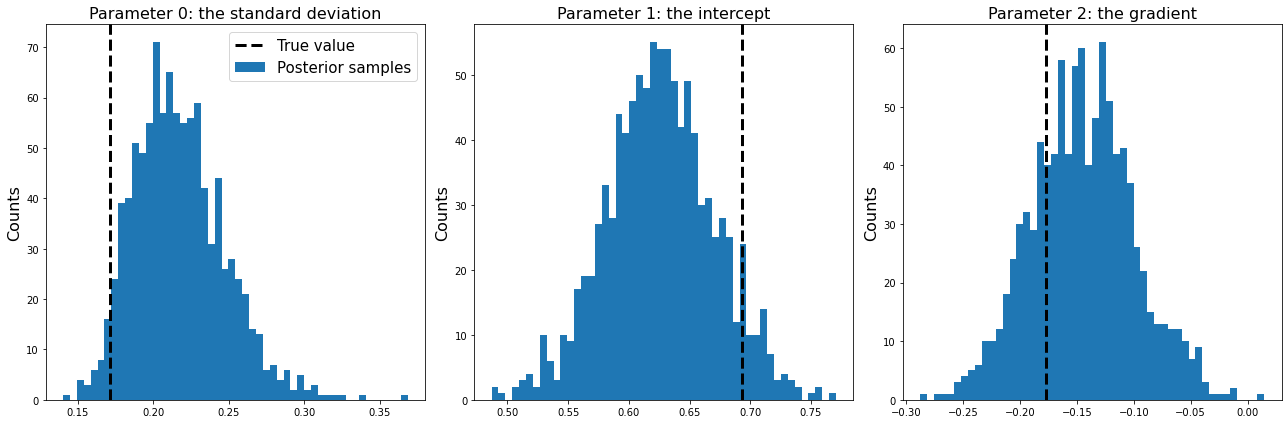

In [4]:
post = nig.PostNormalInverseGamma(prior, explanatory, response)
samples = post.rvs(1000)

fig, axis = plt.subplots(1,3, figsize=(18, 6))
titles = ['Parameter 0: the standard deviation', 'Parameter 1: the intercept', 'Parameter 2: the gradient']
for i in range(3):
    ax = axis[i]
    ax.hist(samples[:,i], bins=50, label='Posterior samples')
    ax.axvline(params[0][i], color='k', lw=3, ls='--', label='True value')
    if i==0:
        ax.legend(fontsize=15)
    ax.set_title(titles[i], fontsize=16)
    ax.set_ylabel('Counts', fontsize=16)

plt.tight_layout()
plt.savefig('toy_regression_posterior.png', dpi=150)
plt.show()

## Marginal likelihood limiting value

### Gradually increasing the data

In [5]:
prior = nig.NormalInverseGamma(a=3, b=1, mu=np.array([[0],[0]]), cov=np.eye(2))

# Draw a toy regression parameters from the prior and 1D explanatory variable from standard normal
n = 100
explanatory, response, params = nig.gen_toy_data(n, prior)
params = prior.rvs(1)
mu = params[:, 1:].T
sigma2 = params[0][0]

# Now perform multiple rounds of Bayesian updating
nrounds = 500
l = []
ntotal = n
for i in range(nrounds):
    # Calibrate Bayesian model 
    post = nig.PostNormalInverseGamma(prior, explanatory, response)
    l.append(post.log_marg_like / ntotal) 
    
    # Now add new data to the model
    new_explanatory =  np.vstack((np.repeat(1, n), np.random.normal(loc=0, scale=1, size=n))).T
    noise = np.random.normal(loc=0, scale=np.sqrt(sigma2), size=n)
    noise = np.reshape(noise, (n, 1))
    new_response = np.dot(new_explanatory, mu) + noise
    
    explanatory = np.vstack((new_explanatory, explanatory))
    response = np.vstack((new_response, response))
    ntotal += n

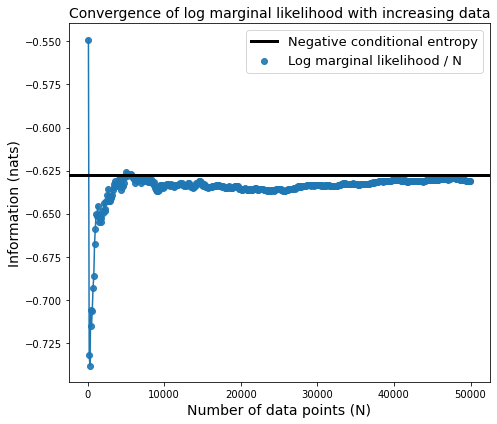

In [6]:
condition_ent = nig.entropy_of_normal(sigma2)

fig, ax = plt.subplots(1, figsize=(7, 6))

ndata = np.arange(n-1, nrounds*n, n)
#ndata = np.arange(nrounds)*n
ax.plot(ndata, l, color='C0')
ax.scatter(ndata, l, alpha=0.9, color='C0', label='Log marginal likelihood / N')
ax.axhline(-condition_ent, lw=3, color='k', label='Negative conditional entropy')

ax.legend(fontsize=13)
ax.set_xlabel('Number of data points (N)', fontsize=14)
ax.set_ylabel('Information (nats)', fontsize=14)
ax.set_title('Convergence of log marginal likelihood with increasing data', fontsize=14)
plt.tight_layout()
plt.show()

## Estimating bounds to the log marginal likelihood
1. Add a function to calculate the log likelihood in the posterior class
2. Sample over the prior an estimate average likelihood (lower bound)
3. Sample over the posterior and estimate average likelihood (upper bound)
4. Add bounds to a plot like the above.

**Extra Credit** Write tools to estimate KL divergence of prior and posterior in both directions. 

In [7]:
prior = nig.NormalInverseGamma(a=3, b=1, mu=np.array([[0],[0]]), cov=np.eye(2))

# Draw a toy regression parameters from the prior and 1D explanatory variable from standard normal
n = 1000
explanatory, response, params = nig.gen_toy_data(n, prior)
params = prior.rvs(1)
mu = params[:, 1:].T
sigma2 = params[0][0]

# Now perform multiple rounds of Bayesian updating
nrounds = 10
l = []
lower = []
upper = []

ntotal = n
t0 = time()
for i in range(nrounds):
    # Calibrate Bayesian model 
    post = nig.PostNormalInverseGamma(prior, explanatory, response)
    l.append(post.log_marg_like / ntotal) 
    #l.append(nig.log_marg_like(explanatory, response, 3, 1, np.array([[0],[0]]), np.eye(2)))
    
    # The upper and lower bounds
    lower.append(nig.estimate_mean_loglike(prior, explanatory, response) / ntotal)
    upper.append(nig.estimate_mean_loglike(post, explanatory, response) / ntotal)
    
    # Now add new data to the model
    new_explanatory =  np.vstack((np.repeat(1, n), np.random.normal(loc=0, scale=1, size=n))).T
    noise = np.random.normal(loc=0, scale=np.sqrt(sigma2), size=n)
    noise = np.reshape(noise, (n, 1))
    new_response = np.dot(new_explanatory, mu) + noise
    
    explanatory = np.vstack((new_explanatory, explanatory))
    response = np.vstack((new_response, response))
    ntotal += n

print('Time taken in minutes:', (time() - t0)/60)

Time taken in minutes: 0.15408335526784261


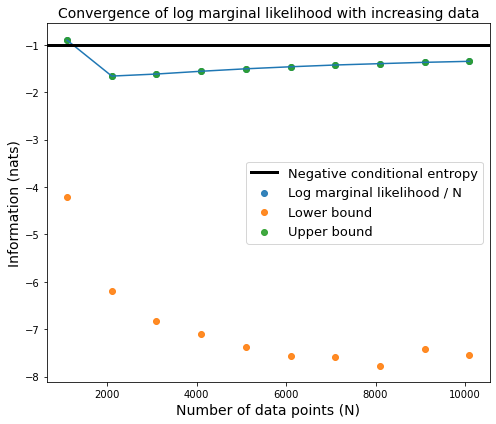

In [8]:
condition_ent = nig.entropy_of_normal(sigma2)

fig, ax = plt.subplots(1, figsize=(7, 6))

ndata = np.arange(n, explanatory.shape[0], n) + 100
ax.plot(ndata, l, color='C0')
ax.scatter(ndata, l, alpha=0.9, color='C0', label='Log marginal likelihood / N')
ax.scatter(ndata, lower, alpha=0.9, color='C1', label='Lower bound')
ax.scatter(ndata, upper, alpha=0.9, color='C2', label='Upper bound')

ax.axhline(-condition_ent, lw=3, color='k', label='Negative conditional entropy')

ax.legend(fontsize=13)
ax.set_xlabel('Number of data points (N)', fontsize=14)
ax.set_ylabel('Information (nats)', fontsize=14)
ax.set_title('Convergence of log marginal likelihood with increasing data', fontsize=14)
plt.tight_layout()
plt.show()

#### The error of the upper bound is $\log(n) / n$

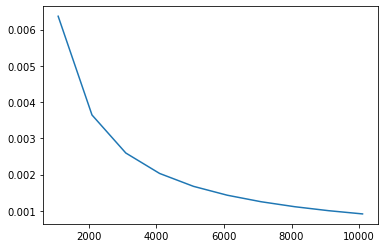

In [9]:
plt.plot(ndata, np.log(ndata)/ndata)
plt.show()

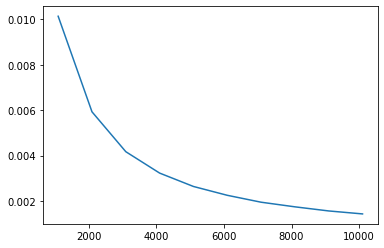

In [10]:
plt.plot(ndata, np.array(upper) - np.array(l))
plt.show()

### Now adding uncertainty to the bounds

In [12]:
prior = nig.NormalInverseGamma(a=3, b=1, mu=np.array([[0],[0]]), cov=np.eye(2))

# Draw a toy regression parameters from the prior and 1D explanatory variable from standard normal
n = 10
explanatory, response, params = nig.gen_toy_data(n, prior)
params = prior.rvs(1)
mu = params[:, 1:].T
sigma2 = params[0][0]

# Now perform multiple rounds of Bayesian updating
nrounds = 10
l = []
lower = []
lower_err = []
upper = []
upper_err = []

nsamps = 5000
ntotal = n
for i in range(nrounds):
    # Calibrate Bayesian model 
    post = nig.PostNormalInverseGamma(prior, explanatory, response)
    l.append(post.log_marg_like / ntotal) 
    
    # The upper and lower bounds
    samples = nig.sample_loglike(prior, explanatory, response, nsamps) / ntotal
    lower.append(samples.mean())
    lower_err.append(2*samples.std()/np.sqrt(nsamps))
    
    samples = nig.sample_loglike(post, explanatory, response, nsamps) / ntotal
    upper.append(samples.mean())
    upper_err.append(2*samples.std()/np.sqrt(nsamps))
    
    # Now add new data to the model
    new_explanatory =  np.vstack((np.repeat(1, n), np.random.normal(loc=0, scale=1, size=n))).T
    noise = np.random.normal(loc=0, scale=np.sqrt(sigma2), size=n)
    noise = np.reshape(noise, (n, 1))
    new_response = np.dot(new_explanatory, mu) + noise
    
    explanatory = np.vstack((new_explanatory, explanatory))
    response = np.vstack((new_response, response))
    ntotal += n

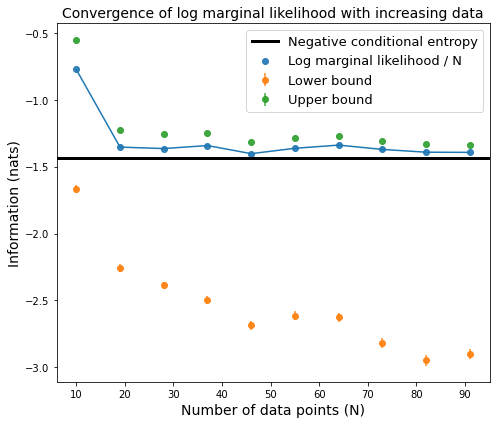

In [13]:
condition_ent = nig.entropy_of_normal(sigma2)

fig, ax = plt.subplots(1, figsize=(7, 6))

ndata = np.arange(n, nrounds*n, nrounds-1)
ax.plot(ndata, l, color='C0')
ax.scatter(ndata, l, alpha=0.9, color='C0', label='Log marginal likelihood / N')
ax.errorbar(ndata, lower, yerr=lower_err, alpha=0.9, color='C1', label='Lower bound', fmt='o')
ax.errorbar(ndata, upper, yerr=upper_err, alpha=0.9, color='C2', label='Upper bound', fmt='o')

ax.axhline(-condition_ent, lw=3, color='k', label='Negative conditional entropy')

ax.legend(fontsize=13)
ax.set_xlabel('Number of data points (N)', fontsize=14)
ax.set_ylabel('Information (nats)', fontsize=14)
ax.set_title('Convergence of log marginal likelihood with increasing data', fontsize=14)
plt.tight_layout()
plt.show()